In [1]:
import torch
torch.set_printoptions(precision=1, sci_mode=False)
device = 'cuda'

In [2]:
run_name = 'pubchem16_dev'

In [3]:
from GRALE.main import GRALE_model
import torch
# Load a Lightning checkpoint
checkpoint_path = f"checkpoints/{run_name}/last.ckpt"
model = GRALE_model.load_from_checkpoint(checkpoint_path)
config = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)["hyper_parameters"]

/tmp/ipykernel_192469/2353755521.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  config = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)["hyper_p

In [4]:
# Load data
from GRALE.data.dataset import DataModule

path_h5 = 'data/h5/PUBCHEM_16.h5'
datamodule = DataModule(
    path_h5=path_h5,
    batch_size=16,
    n_data_epoch=10000,
    n_data_valid=10000
)

---
The full train dataset is of size 13790234.
Every epoch a chunk of size 10000 is loaded.
The entire dataset will be iterated every 1380 epochs.
Consider increasing n_data_epoch for better efficiency.
---
Loading only 10000 samples of the valid dataset in memory.
---


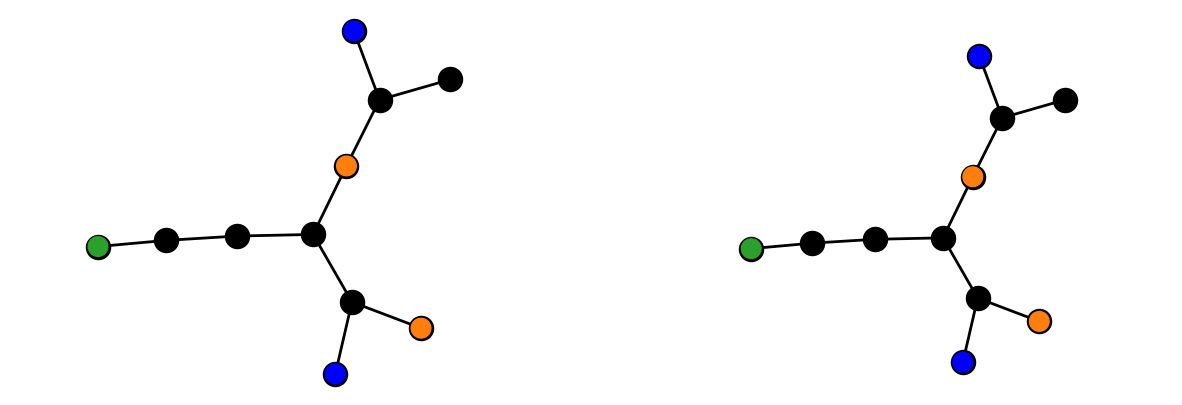

In [5]:
import matplotlib.pyplot as plt
from GRALE.plots import plot_graph, atomic_num_colormap

node_size = 200
frame = False
edge_weight = True
hard_permuter = True

loader_val = datamodule.val_dataloader()
for inputs in loader_val:
    inputs = inputs.to('cuda')
    outputs = model(inputs)
    edit, _ = model.validation_metric(outputs, inputs, permutation_matrices=None)
    for k in range(inputs.batchsize):
        h_inputs = inputs.h[k]
        size = int(h_inputs.sum(dim=-1))
        node_labels_inputs = inputs.nodes.labels[k][:size:]
        node_labels_preds = outputs.nodes.labels[k][:size,:]
        A_inputs = inputs.edges.adjacency[k][:size,:size]
        A_preds = outputs.edges.adjacency[k][:size,:size]

        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
        pos = 'kamada'
        pos = plot_graph(node_labels_inputs,A_inputs,ax=ax1,pos=pos,frame=frame,edge_weight=edge_weight)
        plot_graph(node_labels_preds,A_preds,ax=ax2,pos=pos,frame=frame,edge_weight=edge_weight)
        plt.show()
        break
    break

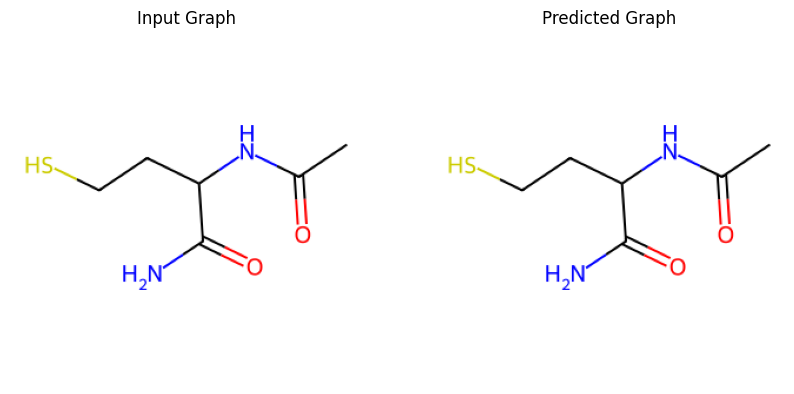

[12:00:49] Explicit valence for atom # 6 N, 4, is greater than permitted


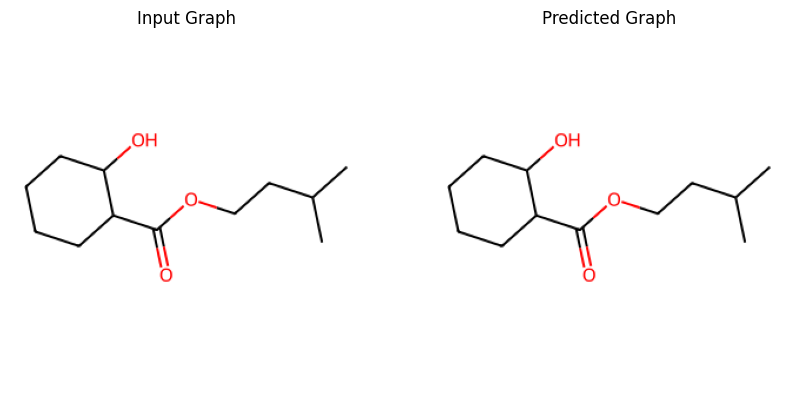

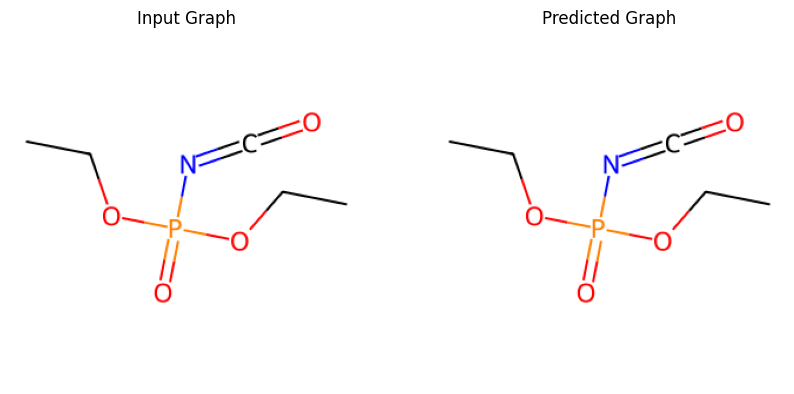

[12:00:49] Explicit valence for atom # 5 N, 6, is greater than permitted


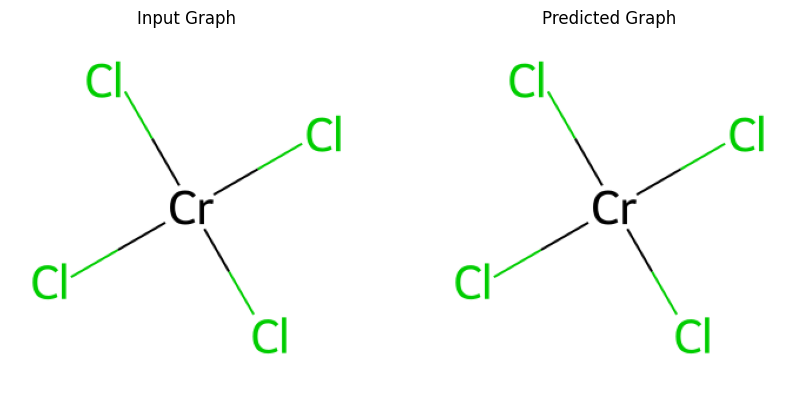

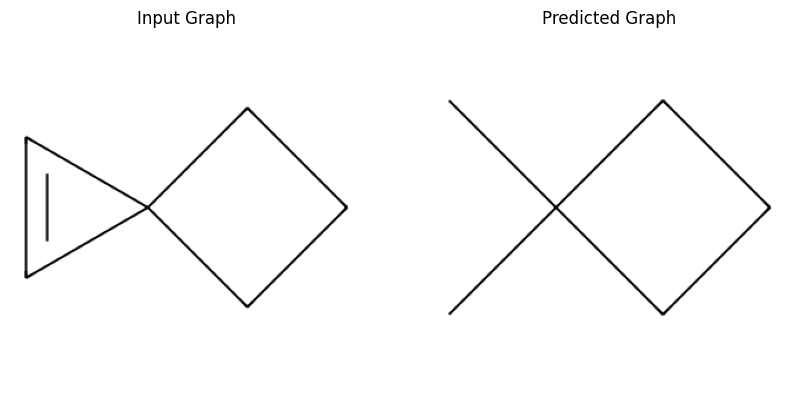

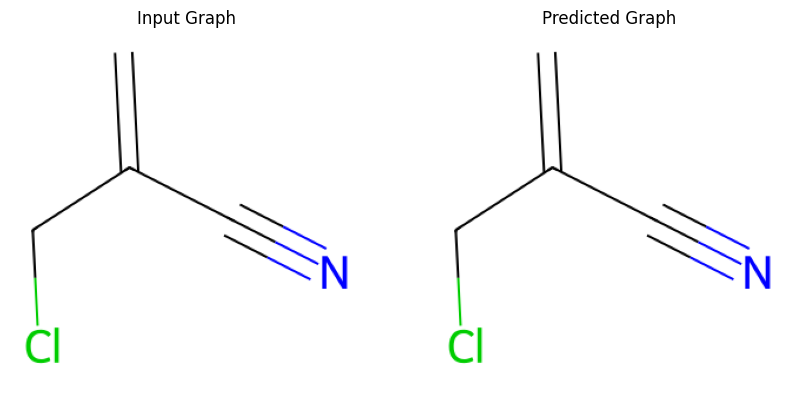

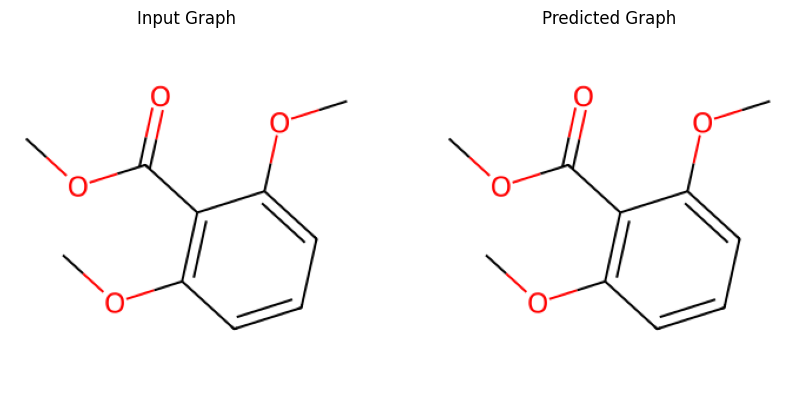

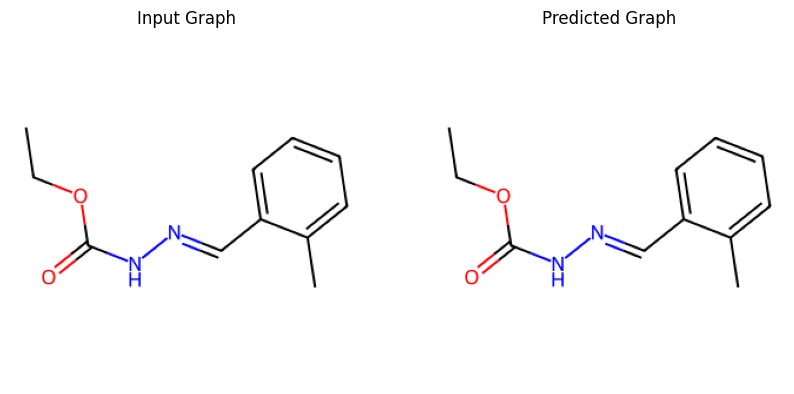

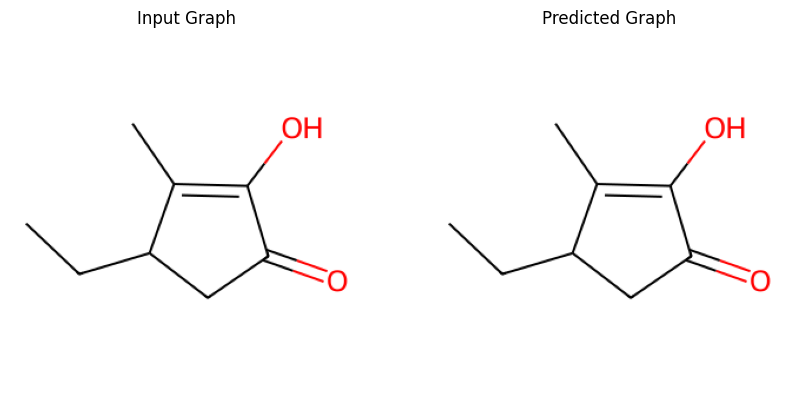

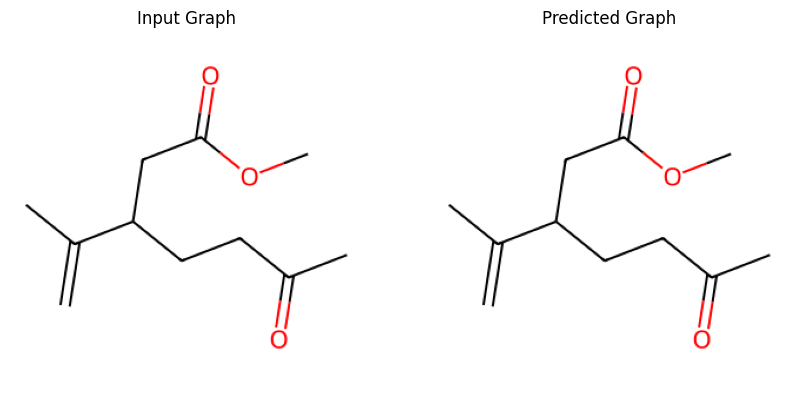

[12:00:50] Explicit valence for atom # 7 C, 5, is greater than permitted


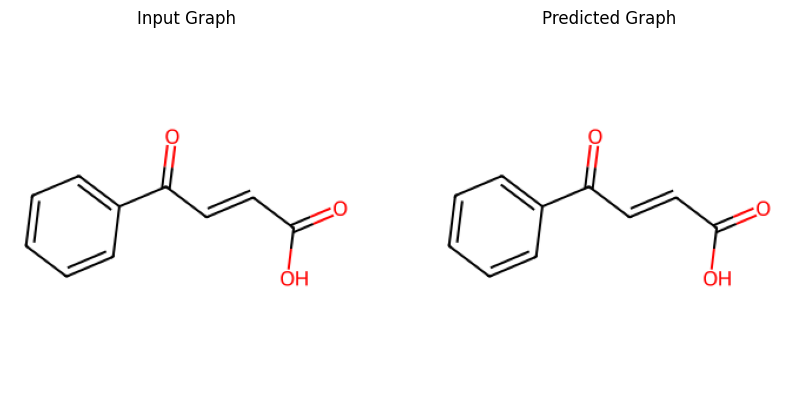

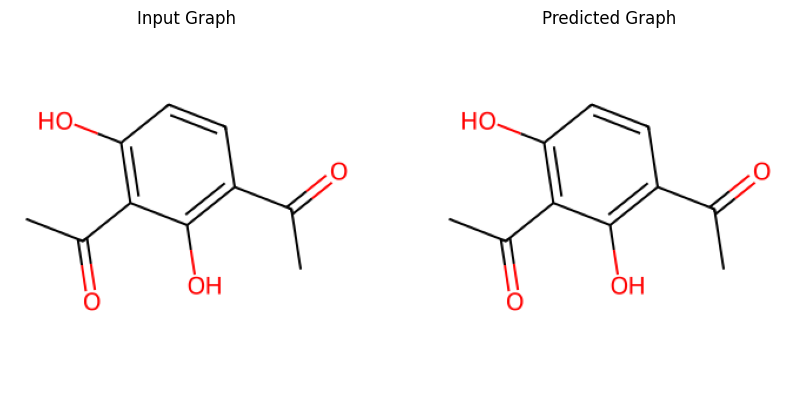

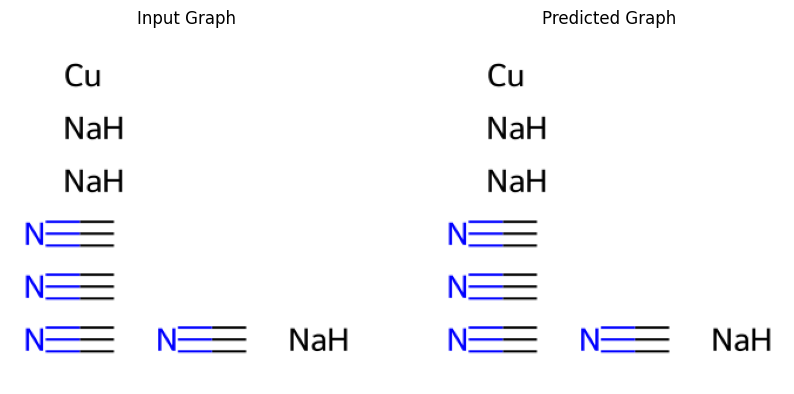

In [7]:
from GRALE.plots import graph_to_rdkit
from rdkit.Chem import Draw

loader_val = datamodule.val_dataloader()
for inputs in loader_val:
    inputs = inputs.to('cuda')
    outputs = model(inputs)
    edit, _ = model.validation_metric(outputs, inputs, permutation_matrices=None)
    outputs.edges.labels = 0.5*(outputs.edges.labels + outputs.edges.labels.permute(0,2,1,3)) # symmetrize
    for k in range(inputs.batchsize):
        h_inputs = inputs.h[k]
        size = int(h_inputs.sum(dim=-1))
        node_labels_inputs = inputs.nodes.labels[k][:size:].cpu().numpy().argmax(-1) # Matrix of size (num_nodes)
        edge_labels_inputs = inputs.edges.labels[k][:size,:size].cpu().numpy().argmax(-1) # Matrix of size (num_edges, num_edges)
        node_labels_preds = outputs.nodes.labels[k][:size,:].detach().cpu().numpy().argmax(-1) # Matrix of size (num_nodes)
        edge_labels_preds = outputs.edges.labels[k][:size,:size]
        edge_labels_preds = outputs.edges.labels[k][:size,:size].detach().cpu().numpy().argmax(-1) # Matrix of size (num_edges, num_edges)
        
        smiles_inputs, mol_inputs = graph_to_rdkit(node_labels_inputs, edge_labels_inputs)
        smiles_targets, mol_targets = graph_to_rdkit(node_labels_preds, edge_labels_preds)

        if smiles_inputs is None or smiles_targets is None:
            continue
        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            img1 = Draw.MolToImage(mol_inputs, size=(300, 300))
            img2 = Draw.MolToImage(mol_targets, size=(300, 300))
            ax1.imshow(img1)
            ax1.set_title("Input Graph")
            ax1.axis('off')
            ax2.imshow(img2)
            ax2.set_title("Predicted Graph")
            ax2.axis('off')
            plt.show()
    break

In [19]:
from GRALE.plots import graph_to_rdkit
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

loader_val = datamodule.val_dataloader()
n_total = 0
n_valid_inputs = 0
n_exact_recons = 0
for inputs in loader_val:
    inputs = inputs.to('cuda')
    outputs = model(inputs)
    edit, _ = model.validation_metric(outputs, inputs, permutation_matrices=None)
    outputs.edges.labels = 0.5*(outputs.edges.labels + outputs.edges.labels.permute(0,2,1,3)) # symmetrize
    for k in range(inputs.batchsize):
        h_inputs = inputs.h[k]
        size = int(h_inputs.sum(dim=-1))
        node_labels_inputs = inputs.nodes.labels[k][:size:].cpu().numpy().argmax(-1) # Matrix of size (num_nodes)
        edge_labels_inputs = inputs.edges.labels[k][:size,:size].cpu().numpy().argmax(-1) # Matrix of size (num_edges, num_edges)
        node_labels_preds = outputs.nodes.labels[k][:size,:].detach().cpu().numpy().argmax(-1) # Matrix of size (num_nodes)
        edge_labels_preds = outputs.edges.labels[k][:size,:size]
        edge_labels_preds = outputs.edges.labels[k][:size,:size].detach().cpu().numpy().argmax(-1) # Matrix of size (num_edges, num_edges)
        
        smiles_inputs, mol_inputs = graph_to_rdkit(node_labels_inputs, edge_labels_inputs)
        smiles_targets, mol_targets = graph_to_rdkit(node_labels_preds, edge_labels_preds)
        
        n_total += 1
        if smiles_inputs is None:
            pass
        else:
            n_valid_inputs += 1
            if smiles_inputs == smiles_targets:
                n_exact_recons += 1

print(f"Exact match: {n_exact_recons}/{n_valid_inputs} = {n_exact_recons/n_valid_inputs:.2%}")
print(f"Valid inputs: {n_valid_inputs}/{n_total} = {n_valid_inputs/n_total:.2%}")



Exact match: 7462/8691 = 85.86%
Valid inputs: 8691/10000 = 86.91%


In [5]:
import torch
run_name = 'pubchem16_dev'
checkpoint_path = f"checkpoints/{run_name}/last.ckpt"
config = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)["hyper_parameters"]

/tmp/ipykernel_196232/2710302284.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  config = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)["hyper_p

In [6]:
config

{'alpha_adjacency': 0.2,
 'alpha_edge_features': 0.1,
 'alpha_edge_labels': 0.2,
 'alpha_h': 1,
 'alpha_marginals': 1,
 'alpha_node_features': 0.1,
 'alpha_node_labels': 1,
 'weight_decay': 0,
 'base_lr': 0.0001,
 'max_grad_norm': 1.0,
 'batchsize': 64,
 'n_workers': 6,
 'n_warmup_steps': 2000,
 'n_grad_steps': 300000,
 'n_data_epoch': 128000,
 'n_data_valid': 4000,
 'dataset': 'PUBCHEM_32',
 'matcher_model': 'sinkhorn',
 'encoder_model': 'evoformer',
 'decoder_model': 'evoformer',
 'n_layers': 3,
 'n_heads': 4,
 'norm_post_or_pre': 'pre',
 'triangular_attention_mode': 'none',
 'triangular_multiplication_mode': 'row',
 'node_features_dim': 32,
 'node_hidden_dim': 256,
 'node_labels_dim': 32,
 'node_model_dim': 256,
 'node_pos_dim': 16,
 'edge_features_dim': 1,
 'edge_hidden_dim': None,
 'edge_labels_dim': 6,
 'edge_model_dim': 128,
 'edge_pos_dim': 32,
 'n_nodes_max': 16,
 'graph_embedding_dim': 128,
 'graph_embedding_size': 4,
 'matcher_dim': 64,
 'normalize_cost_matrix': True,
 'max_